In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split


In [2]:
def read_data(data_path, data_type):
    if data_type == 'before':
        data_path = os.path.join(data_path, 'A')
    elif data_type == 'after':
        data_path = os.path.join(data_path, 'B')
    elif data_type == 'label':
        data_path = os.path.join(data_path, 'label')
    else:
        print('data_type is not correct')
        return None

    data = []
    for file in os.listdir(data_path):
        img = cv2.imread(os.path.join(data_path, file))
        data.append(img)
    return data

# display images {before, after, labels}
def display_images(before, after, labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    plt.show()

In [3]:
def plot_row(images, titles):
    fig, ax = plt.subplots(1, len(images), figsize=(10, 20))
    ax[0].imshow(images[0].astype("uint8"))
    ax[0].set_title(titles[0])
    ax[0].axis("off")
    for i in range(len(images) - 1):
        ax[i+1].imshow(images[i + 1])
        ax[i+1].set_title(titles[i + 1])
        ax[i+1].axis("off")
    plt.tight_layout()
    plt.show()

In [4]:
training_path = '../trainval/'

In [5]:
before_images = read_data(training_path,'before')
after_images = read_data(training_path, 'after')
labels = read_data(training_path,'label')

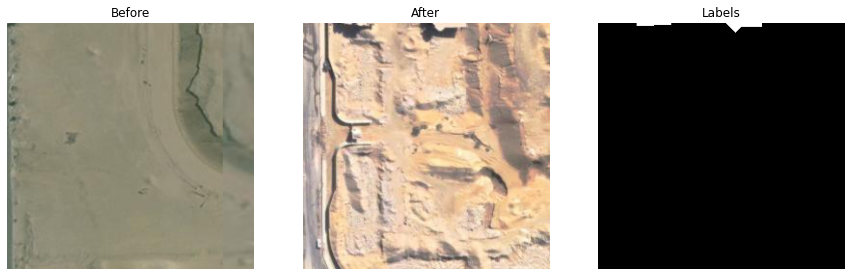

In [6]:
index = 0
# print first image in before_images, after_images, and labels in the same row
display_images(before_images[index], after_images[index], labels[index])

In [7]:
# Perform preprocessing steps for each image
preprocessed_images_A = []
preprocessed_images_B = []

# Image Enhancement (Contrast Stretching) parameters
clahe_clip_limit = 2.0
clahe_tile_grid_size = (8, 8)
clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size)

# Normalization parameters
norm_alpha = 0
norm_beta = 255

for image_A, image_B in zip(before_images, after_images):
    # Image Enhancement (Contrast Stretching)
    enhanced_image_A = clahe.apply(image_A[:,:,0])  
    enhanced_image_B = clahe.apply(image_B[:,:,0])

    # Normalization
    normalized_image_A = cv2.normalize(enhanced_image_A, None, alpha=norm_alpha, beta=norm_beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_image_B = cv2.normalize(enhanced_image_B, None, alpha=norm_alpha, beta=norm_beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Noise Reduction (Gaussian Blur) parameters
    blur_kernel_size = (5, 5)
    blur_sigma = 0

    # Noise Reduction (Gaussian Blur)
    blurred_image_A = cv2.GaussianBlur(normalized_image_A, blur_kernel_size, blur_sigma)
    blurred_image_B = cv2.GaussianBlur(normalized_image_B, blur_kernel_size, blur_sigma)

    # Append preprocessed images to the list
    preprocessed_images_A.append(blurred_image_A)
    preprocessed_images_B.append(blurred_image_B)


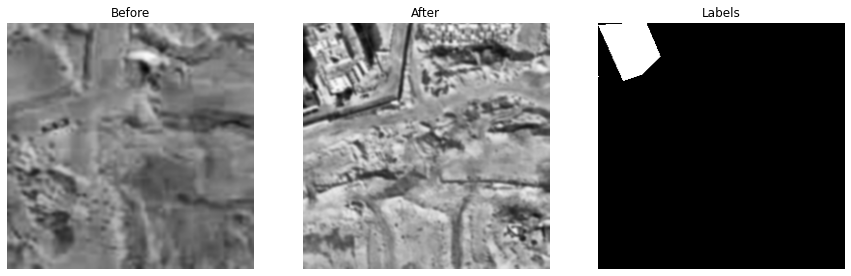

In [8]:
index = 1
# plot the first preprocessed image
display_images(preprocessed_images_A[index], preprocessed_images_B[index], labels[index])


In [9]:
def preprocess_images(before_images, after_images, gamma_values):
    """
    Preprocesses a list of before and after satellite images using gamma correction.

    Args:
    - before_images: List of NumPy arrays representing the before images (RGB).
    - after_images: List of NumPy arrays representing the after images (RGB).
    - gamma_values: List of gamma values to apply for gamma correction.

    Returns:
    - preprocessed_images_A: List of preprocessed before images.
    - preprocessed_images_B: List of preprocessed after images.
    """
    preprocessed_images_A = []
    preprocessed_images_B = []

    for gamma in gamma_values:
        for image_A, image_B in zip(before_images, after_images):

            # Gamma Correction
            corrected_image_A = exposure.adjust_gamma(image_A, gamma)
            corrected_image_B = exposure.adjust_gamma(image_B, gamma)
            
            # Append preprocessed images to the list
            preprocessed_images_A.append(corrected_image_A)
            preprocessed_images_B.append(corrected_image_B)

    return preprocessed_images_A, preprocessed_images_B


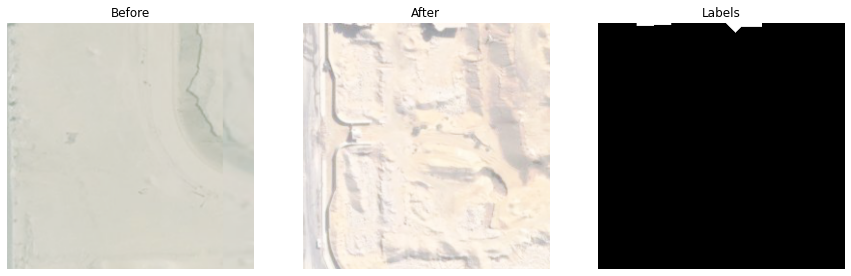

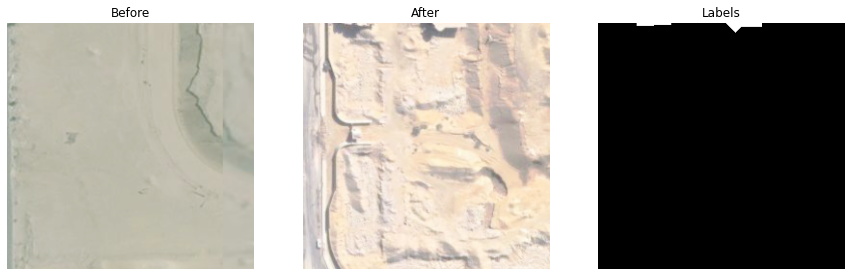

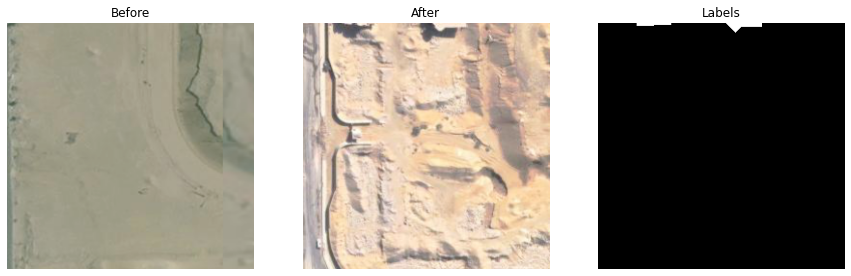

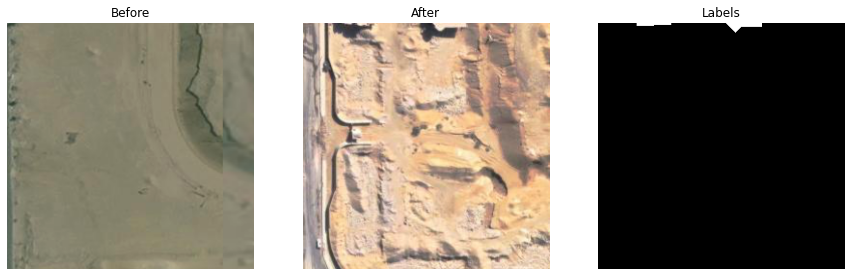

In [10]:
# Example usage
gamma_values = [0.3, 0.5, 0.8, 1.1]  # Gamma values to apply

# take first image in before_images and after_images
before_images2 = before_images[:1]
after_images2 = after_images[:1]

preprocessed_images_A, preprocessed_images_B = preprocess_images(before_images2, after_images2, gamma_values)

# Display the first preprocessed image for each gamma value
for i, gamma in enumerate(gamma_values):
    display_images(preprocessed_images_A[i], preprocessed_images_B[i], labels[0])


In [11]:
def increase_saturation(before_images, after_images, factor):
    """
    Increases the saturation of an image using the HSV color space.

    Args:
    - image: NumPy array representing the image (RGB).
    - factor: Factor to increase the saturation by.

    Returns:
    - image: NumPy array representing the image with increased saturation (RGB).
    """
    preprocessed_images_A = []
    preprocessed_images_B = []

    for image_A, image_B in zip(before_images, after_images):
        # Convert the image to the HSV color space
        hsv_image_A = color.rgb2hsv(image_A)
        hsv_image_B = color.rgb2hsv(image_B)

        # Increase the saturation
        hsv_image_A[:, :, 1] *= factor
        hsv_image_B[:, :, 1] *= factor

        # convert to RGB
        enhanced_image_A = color.hsv2rgb(hsv_image_A)
        enhanced_image_B = color.hsv2rgb(hsv_image_B)

        # multiply by 255
        enhanced_image_A = (enhanced_image_A * 255).astype(np.uint8)
        enhanced_image_B = (enhanced_image_B * 255).astype(np.uint8)

        # Append preprocessed images to the list
        preprocessed_images_A.append(enhanced_image_A)
        preprocessed_images_B.append(enhanced_image_B)

    return preprocessed_images_A, preprocessed_images_B

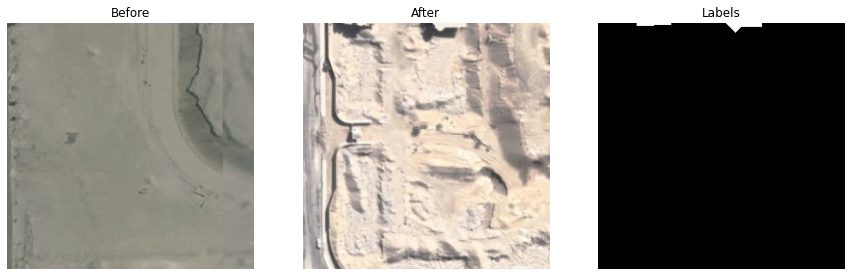

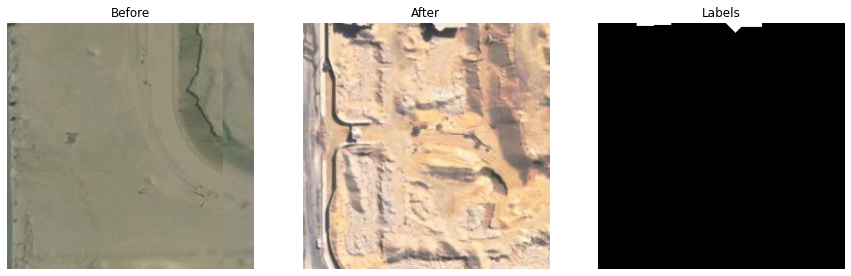

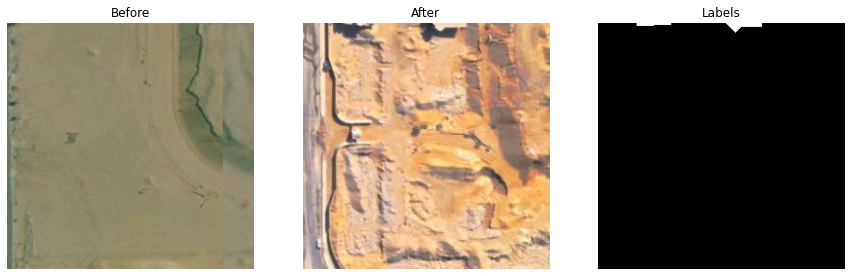

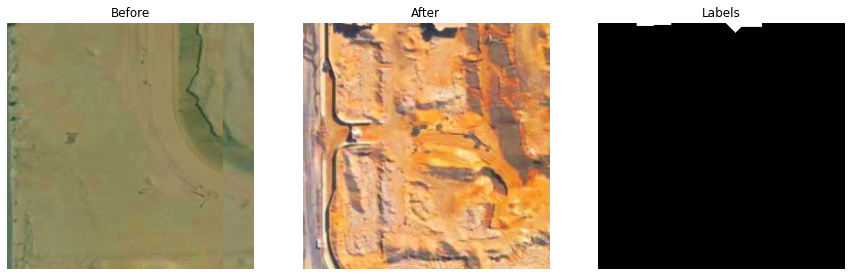

In [12]:
# test the function
factor = [0.5, 1.0, 1.5, 2.0]  

before_images2 = before_images[:1]
after_images2 = after_images[:1]

for f in factor:
    preprocessed_images_A, preprocessed_images_B = increase_saturation(before_images2, after_images2, f)
    display_images(preprocessed_images_A[0], preprocessed_images_B[0], labels[0])


## Colors Features

In [13]:
# get colors distribution for each class

class_A = before_images
class_B = after_images
class_labels = labels

class_A_colors = []
for image in class_A:
    class_A_colors.append(np.mean(image, axis=(0, 1)))
class_A_colors = np.array(class_A_colors)

class_B_colors = []
for image in class_B:
    class_B_colors.append(np.mean(image, axis=(0, 1)))
class_B_colors = np.array(class_B_colors)


In [14]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

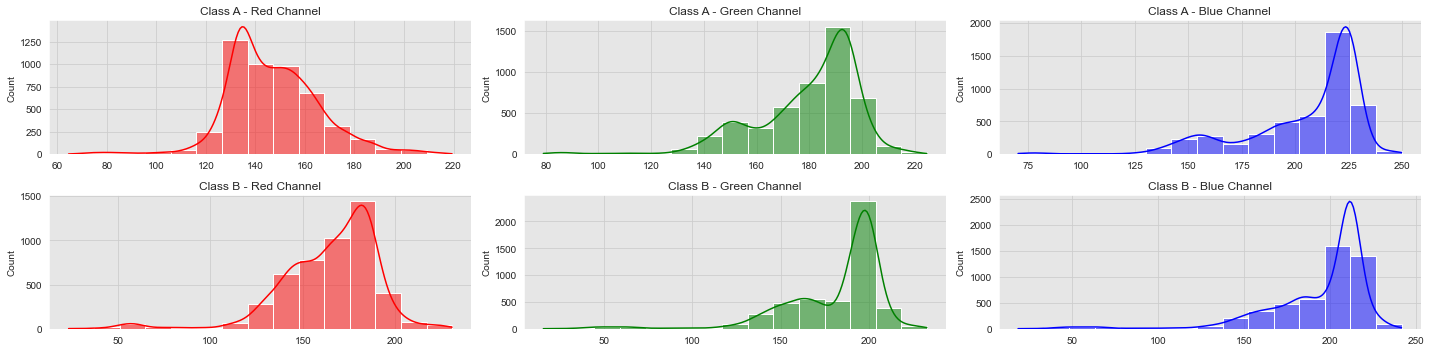

In [15]:
bins = 15
fig, ax = plt.subplots(2, 3, figsize=(20, 5))
sns.histplot(class_A_colors[:, 0], bins=bins, ax=ax[0, 0], color='red', kde=True)
sns.histplot(class_A_colors[:, 1], bins=bins, ax=ax[0, 1], color='green', kde=True)
sns.histplot(class_A_colors[:, 2], bins=bins, ax=ax[0, 2], color='blue', kde=True)

sns.histplot(class_B_colors[:, 0], bins=bins, ax=ax[1, 0], color='red', kde=True)
sns.histplot(class_B_colors[:, 1], bins=bins, ax=ax[1, 1], color='green', kde=True)
sns.histplot(class_B_colors[:, 2], bins=bins, ax=ax[1, 2], color='blue', kde=True)

ax[0, 0].set_title('Class A - Red Channel')
ax[0, 1].set_title('Class A - Green Channel')
ax[0, 2].set_title('Class A - Blue Channel')

ax[1, 0].set_title('Class B - Red Channel')
ax[1, 1].set_title('Class B - Green Channel')
ax[1, 2].set_title('Class B - Blue Channel')

plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13212\3246286981.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13212\3246286981.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13212\3246286981.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')


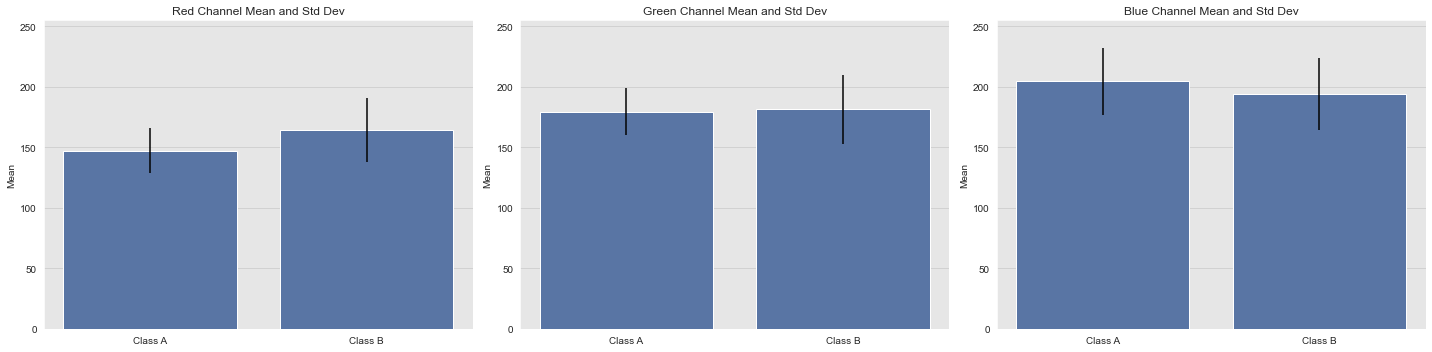

In [16]:
# Calculate mean and standard deviation for each color channel
class_A_mean = np.mean(class_A_colors, axis=0)
class_A_std = np.std(class_A_colors, axis=0)

class_B_mean = np.mean(class_B_colors, axis=0)
class_B_std = np.std(class_B_colors, axis=0)

# Plotting
channels = ['Red', 'Green', 'Blue']
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, channel in enumerate(channels):
    sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')
    ax[i].errorbar(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], yerr=[class_A_std[i], class_B_std[i]], fmt='none', color='black')

    ax[i].set_title(f'{channel} Channel Mean and Std Dev')
    ax[i].set_ylabel('Mean')
    ax[i].set_ylim(0, 255)

plt.tight_layout()
plt.show()


In [17]:
before_images = np.array(before_images)
after_images = np.array(after_images)
labels = np.array(labels)


In [23]:
# Calculate histogram differences for training images
bins = 15
X_train_hist_diff = []
Y_train_hist_diff = []

for image_A, image_B, label in zip(before_images, after_images, labels):
    A_red = np.histogram(image_A[:, :, 0], bins=bins)[0]
    A_green = np.histogram(image_A[:, :, 1], bins=bins)[0]
    A_blue = np.histogram(image_A[:, :, 2], bins=bins)[0]

    B_red = np.histogram(image_B[:, :, 0], bins=bins)[0]
    B_green = np.histogram(image_B[:, :, 1], bins=bins)[0]
    B_blue = np.histogram(image_B[:, :, 2], bins=bins)[0]
    
    red_diff = np.abs(A_red - B_red)
    green_diff = np.abs(A_green - B_green)
    blue_diff = np.abs(A_blue - B_blue)

    red_diff_mean = np.mean(red_diff)
    green_diff_mean = np.mean(green_diff)
    blue_diff_mean = np.mean(blue_diff)

    x_train_mean = np.array([red_diff_mean, green_diff_mean, blue_diff_mean])
    X_train_hist_diff.append(x_train_mean)

    # take the average of each channel
    y_red = np.mean(label[:, :, 0])
    y_green = np.mean(label[:, :, 1])
    y_blue = np.mean(label[:, :, 2])

    y_train_hist_diff = np.mean([y_red, y_green, y_blue])
    Y_train_hist_diff.append(y_train_hist_diff)

X_train_hist_diff = np.array(X_train_hist_diff)
Y_train_hist_diff = np.array(Y_train_hist_diff)


In [24]:
for i in X_train_hist_diff:
    print(i)

for i in Y_train_hist_diff:
    print(i)

[3777.33333333 4769.06666667 5786.66666667]
[4197.06666667 6180.13333333 6991.86666667]
[1509.2        3593.33333333 5554.66666667]
[3882.93333333 4895.86666667 7135.06666667]
[3617.6        4742.66666667 7002.93333333]
[4312.53333333 2361.46666667 6328.66666667]
[1803.33333333 3517.2        4578.        ]
[2711.06666667 2560.53333333 5475.46666667]
[2094.         3888.93333333 6234.26666667]
[2821.73333333 5933.2        6796.66666667]
[2890.93333333 4285.86666667 7510.        ]
[3824.4        6184.53333333 7619.6       ]
[2005.73333333 5180.66666667 6041.2       ]
[2849.06666667 2711.86666667 5388.66666667]
[2667.6        7826.8        8048.53333333]
[3081.6 4036.8 4723.6]
[2284.4        5428.93333333 6754.13333333]
[4441.2        3715.06666667 6329.86666667]
[5816.53333333 5784.93333333 6248.4       ]
[5951.46666667 6033.86666667 5637.6       ]
[3791.06666667 4863.2        5908.93333333]
[3022.4        4585.86666667 5372.26666667]
[2920.53333333 4547.6        5675.73333333]
[1745.333

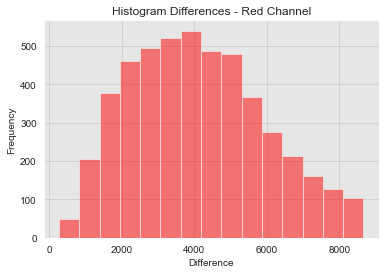

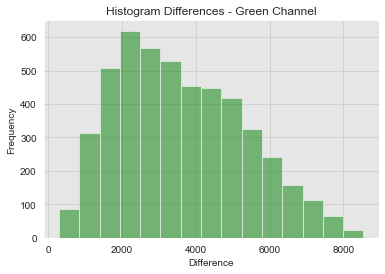

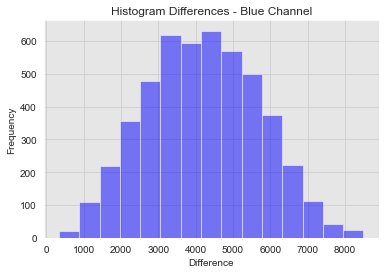

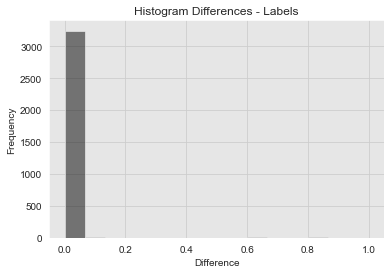

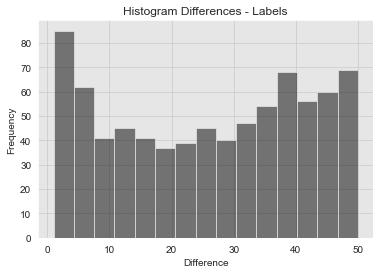

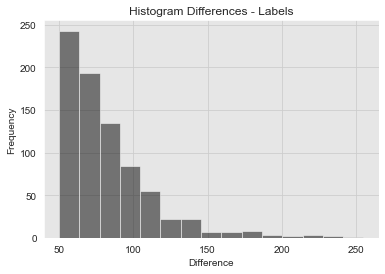

In [39]:
# plot histogram differences of the red channel for x_train_hist_diff
plt.hist(X_train_hist_diff[:, 0], bins=15, color='red', alpha=0.5)
plt.title('Histogram Differences - Red Channel')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

# plot histogram differences of the green channel for x_train_hist_diff
plt.hist(X_train_hist_diff[:, 1], bins=15, color='green', alpha=0.5)
plt.title('Histogram Differences - Green Channel')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

# plot histogram differences of the blue channel for x_train_hist_diff
plt.hist(X_train_hist_diff[:, 2], bins=15, color='blue', alpha=0.5)
plt.title('Histogram Differences - Blue Channel')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

# plot histogram differences of the labels for y_train_hist_diff the x axis has max value of 50
plt.hist(Y_train_hist_diff, bins=15, color='black', alpha=0.5, range=(0, 1))
plt.title('Histogram Differences - Labels')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

# plot histogram differences of the labels for y_train_hist_diff the x axis has max value of 50
plt.hist(Y_train_hist_diff, bins=15, color='black', alpha=0.5, range=(1, 50))
plt.title('Histogram Differences - Labels')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

# plot histogram differences of the labels for y_train_hist_diff the x axis has max value of 50
plt.hist(Y_train_hist_diff, bins=15, color='black', alpha=0.5, range=(50, 255))
plt.title('Histogram Differences - Labels')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()



In [37]:
# convert y_train_hist_diff to binary
threshold = 50
Y_train_hist_diff_binary = np.where(Y_train_hist_diff < threshold, 0, 1)

for i in Y_train_hist_diff_binary:
    print(i)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [38]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_hist_diff, Y_train_hist_diff_binary, test_size=0.2, random_state=42)

# train a random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# make predictions
y_pred = rf_classifier.predict(X_test)

# calculate accuracy and f1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.8295687885010267
F1 Score: 0.2589285714285714


In [33]:
# try SVC classifier
svc_classifier = SVC(random_state=42)
svc_classifier.fit(X_train, y_train)

# make predictions
y_pred = svc_classifier.predict(X_test)

# calculate accuracy and f1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

Accuracy: 0.75564681724846
F1 Score: 0.5062240663900415


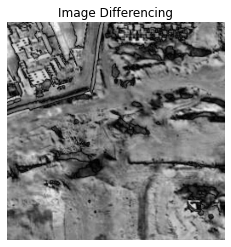

In [17]:
# Implement Change detection using at one classical technique(Image Differencing, Ratioing, CVA, ...).
index = 1
# Image Differencing
def image_differencing(before, after):
    before = cv2.cvtColor(before, cv2.COLOR_BGR2GRAY)
    after = cv2.cvtColor(after, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(before, after)
    return diff

# display image differencing
diff = image_differencing(before_images[index], after_images[index])
plt.imshow(diff, cmap='gray')
plt.title('Image Differencing')
plt.axis('off')
plt.show()

In [10]:
# Read the images
before = before_images[index]
after = after_images[index]

# Convert BGR to NIR and red bands
nir_band1 = before[:,:,2]  # Assuming NIR is in the third channel
red_band1 = before[:,:,0]

nir_band2 = after[:,:,2]  # Assuming NIR is in the third channel
red_band2 = after[:,:,0]

# Compute NDVI
denominator1 = nir_band1 + red_band1
ndvi1 = np.where(denominator1 == 0, 0, (nir_band1 - red_band1) / denominator1)

denominator2 = nir_band2 + red_band2
ndvi2 = np.where(denominator2 == 0, 0, (nir_band2 - red_band2) / denominator2)

# Normalize NDVI
normalized_ndvi1 = (ndvi1 - np.min(ndvi1)) / (np.max(ndvi1) - np.min(ndvi1))
normalized_ndvi2 = (ndvi2 - np.min(ndvi2)) / (np.max(ndvi2) - np.min(ndvi2))

# Compute the difference
ndvi_difference = normalized_ndvi2 - normalized_ndvi1


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23276\1270607478.py:14: RuntimeWarning: divide by zero encountered in divide
  ndvi1 = np.where(denominator1 == 0, 0, (nir_band1 - red_band1) / denominator1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23276\1270607478.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi1 = np.where(denominator1 == 0, 0, (nir_band1 - red_band1) / denominator1)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23276\1270607478.py:17: RuntimeWarning: divide by zero encountered in divide
  ndvi2 = np.where(denominator2 == 0, 0, (nir_band2 - red_band2) / denominator2)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23276\1270607478.py:17: RuntimeWarning: invalid value encountered in divide
  ndvi2 = np.where(denominator2 == 0, 0, (nir_band2 - red_band2) / denominator2)


In [11]:
def jaccard_index(before, after):
    intersection = np.logical_and(before, after)
    union = np.logical_or(before, after)
    return np.sum(intersection) / np.sum(union)

In [12]:
j_index = jaccard_index(ndvi_difference, labels[index])
print("Jaccard Index:", j_index)

ValueError: operands could not be broadcast together with shapes (256,256) (256,256,3) 